    # ACC: Accuracy	-> (Number of Correct Predictions) / (Total Number of Predictions
    # FPR: False Positive Rate	-> Number of FP / (FP +TN)
    # AUC: Area under the ROC curve	-> scikit-learn
    # Ya: Yield of actives 	-> TP/(TP+FP)
    # EF: Enrichment Factor	-> ((TP)/(TP+FP))((tp+fn)/(tp+tn+fp+fn))
    # REF: Relative Enrichment Factor -> 100*tp/min(tp+fp,tp+fn)

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc, confusion_matrix, ConfusionMatrixDisplay


import os 
from pathlib import Path

In [33]:
# paths
base_dir = Path(os.getcwd())/"implementation"
result_dir = base_dir / "data/results/ACHE"

In [34]:
def calc_metrics_from_result_df(df: pd.DataFrame, name: str):
    label = df["LABEL"]
    pred = df["PRED"]

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    for i, v in enumerate(pred):
        if v == 1 and label[i] == 1:
            true_positive += 1
        elif v == 1 and label[i] == 0:
            false_positive += 1
        elif v == 0 and label[i] == 0:
            true_negative += 1
        else:
            false_negative += 1

    resultdf = pd.DataFrame()
    resultdf["name"] = [name]
    resultdf["ACC"] = [(true_positive + true_negative) / len(label)]
    resultdf["FPR"] = [(false_positive) / (false_positive + true_negative)]
    resultdf["AUC"] = roc_auc_score(label, pred)
    resultdf["EF"] = [
        ((true_positive) / (true_positive + false_positive))
        / ((true_positive + false_negative) / (len(label)))
    ]
    resultdf["REF"] = [
        (100 * true_positive)
        / min((true_positive + false_positive), (true_positive + false_negative))
    ]
    return resultdf


def print_roc_curve(df: pd.DataFrame):
    label = df["LABEL"]
    pred = df["PRED"]

    fpr, tpr, thresholds = roc_curve(label, pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(
        fpr=fpr,
        tpr=tpr,
        roc_auc=roc_auc,
        estimator_name="ROC Curve",
    )
    display.plot()
    plt.show()


def print_conf_matrix(df: pd.DataFrame):
    label = df["LABEL"]
    pred = df["PRED"]
    label = ["active" if i == 1 else "inactive" for i in label]
    pred = ["active" if i == 1 else "inactive" for i in pred]

    cm = confusion_matrix(label, pred, labels=["active","inactive"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["active","inactive"])
    disp.plot()


### load results


In [35]:
res = {
    "baseline_rf": pd.read_csv(result_dir / "baseline_rf.csv"),
    "baseline_nn": pd.read_csv(result_dir / "baseline_nn.csv"),
    "baseline_knn": pd.read_csv(result_dir / "baseline_knn.csv"),
    "fe_rf_mdi_nn": pd.read_csv(result_dir / "fe_rf_mdi_nn.csv"),
    "fe_rf_per_nn": pd.read_csv(result_dir / "fe_rf_per_nn.csv"),
    "fe_rf_mdi_knn": pd.read_csv(result_dir / "fe_rf_mdi_knn.csv"),
    "fe_rf_per_knn": pd.read_csv(result_dir / "fe_rf_per_knn.csv"),
    "fe_rf_mdi_rf": pd.read_csv(result_dir / "fe_rf_mdi_rf.csv"),
    "fe_rf_per_rf": pd.read_csv(result_dir / "fe_rf_per_rf.csv"),
    "fe_freq_rf": pd.read_csv(result_dir / "fe_freq_rf.csv"),
    "fe_freq_nn": pd.read_csv(result_dir / "fe_freq_nn.csv"),
    "fe_freq_knn": pd.read_csv(result_dir / "fe_freq_knn.csv"),
    "fe_nonhydrop_rf": pd.read_csv(result_dir / "fe_nonhydrop_rf.csv"),
    "fe_nonhydrop_nn": pd.read_csv(result_dir / "fe_nonhydrop_nn.csv"),
    "fe_nonhydrop_knn": pd.read_csv(result_dir / "fe_nonhydrop_knn.csv"),
    "fe_pca_rf": pd.read_csv(result_dir / "fe_pca_rf.csv"),
    "fe_pca_nn": pd.read_csv(result_dir / "fe_pca_nn.csv"),
    "fe_pca_knn": pd.read_csv(result_dir / "fe_pca_knn.csv"),
    "fe_smote_rf": pd.read_csv(result_dir / "fe_smote_rf.csv"),
    "fe_smote_nn": pd.read_csv(result_dir / "fe_smote_nn.csv"),
    "fe_smote_knn": pd.read_csv(result_dir / "fe_smote_knn.csv"),
}


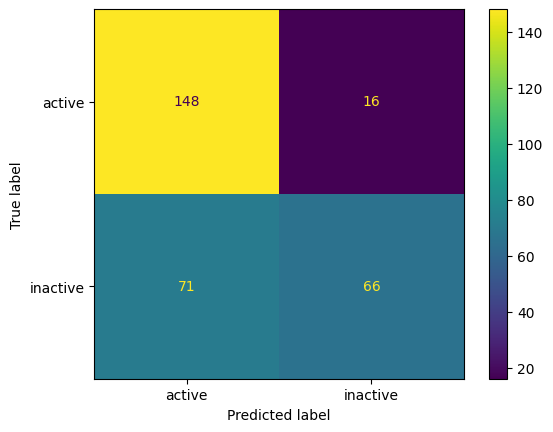

In [36]:
print_conf_matrix(res["fe_freq_knn"])

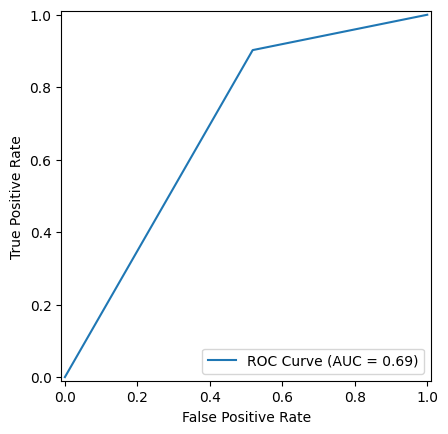

In [37]:
print_roc_curve(res["fe_freq_knn"])

In [38]:

r = pd.DataFrame()
for k,v in res.items():
    r = pd.concat([r,calc_metrics_from_result_df(v,name=k)])

r.sort_values("ACC",ascending=False)

,name,ACC,FPR,AUC,EF,REF
0,fe_rf_per_rf,0.813953,0.291971,0.805234,1.444862,90.243902
0,baseline_rf,0.810631,0.328467,0.799181,1.416120,92.682927
0,fe_freq_rf,0.803987,0.313869,0.794285,1.422168,90.243902
0,fe_smote_rf,0.800664,0.335766,0.789434,1.404617,91.463415
0,fe_nonhydrop_rf,0.800664,0.335766,0.789434,1.404617,91.463415
0,fe_pca_rf,0.784053,0.335766,0.774190,1.393341,88.414634
0,fe_nonhydrop_nn,0.784053,0.291971,0.777795,1.425228,84.756098
0,fe_rf_per_nn,0.777409,0.291971,0.771698,1.420594,83.536585
0,fe_smote_nn,0.770764,0.299270,0.764999,1.410225,82.926829
0,baseline_nn,0.767442,0.291971,0.762551,1.413443,81.707317


In [39]:
# print statistics for each algorithm

algo = ["_rf", "_nn", "_knn"]

for a in algo:
    df = r[r["name"].str.endswith(a)].sort_values("ACC", ascending=False)
    print(a)
    print(df)
    print(
        df.to_latex(
            index=False,
            formatters={"name": str.upper},
            float_format="{:.4f}".format,
        )
    )

_rf
              name       ACC       FPR       AUC        EF        REF
0     fe_rf_per_rf  0.813953  0.291971  0.805234  1.444862  90.243902
0      baseline_rf  0.810631  0.328467  0.799181  1.416120  92.682927
0       fe_freq_rf  0.803987  0.313869  0.794285  1.422168  90.243902
0  fe_nonhydrop_rf  0.800664  0.335766  0.789434  1.404617  91.463415
0      fe_smote_rf  0.800664  0.335766  0.789434  1.404617  91.463415
0        fe_pca_rf  0.784053  0.335766  0.774190  1.393341  88.414634
0     fe_rf_mdi_rf  0.508306  0.357664  0.519339  1.046481  57.017544
\begin{tabular}{lrrrrr}
\toprule
name & ACC & FPR & AUC & EF & REF \\
\midrule
FE_RF_PER_RF & 0.8140 & 0.2920 & 0.8052 & 1.4449 & 90.2439 \\
BASELINE_RF & 0.8106 & 0.3285 & 0.7992 & 1.4161 & 92.6829 \\
FE_FREQ_RF & 0.8040 & 0.3139 & 0.7943 & 1.4222 & 90.2439 \\
FE_NONHYDROP_RF & 0.8007 & 0.3358 & 0.7894 & 1.4046 & 91.4634 \\
FE_SMOTE_RF & 0.8007 & 0.3358 & 0.7894 & 1.4046 & 91.4634 \\
FE_PCA_RF & 0.7841 & 0.3358 & 0.7742 & 1.3933 & 

In [40]:

df_acc = pd.read_csv(result_dir/"val/ache_val.csv",sep=",",index_col="Index")
df_acc

,Name,Validation_Accuracy
Index,,
0,baseline_rf,0.836151
1,baseline_knn,0.743651
2,baseline_nn,0.780100
3,fe_freq_knn,0.766429
4,fe_freq_rf,0.810675
5,fe_freq_nn,0.718000
6,fe_nonhydrop_nn,0.737600
7,fe_nonhydrop_rf,0.804960
8,fe_nonhydrop_knn,0.755000


In [42]:
algo = ["_rf", "_nn", "_knn"]

for a in algo:
    d = df_acc[df_acc["Name"].str.endswith(a)].sort_values(
        "Validation_Accuracy", ascending=False
    )
    print(a)
    print(d)
    print(
        d.to_latex(
            index=False,
            formatters={"name": str.upper},
            float_format="{:.4f}".format,
            escape=True,
            caption="Feature Engineering Validation Accuracy"
        )
    )

_rf
                  Name  Validation_Accuracy
Index                                      
19         fe_smote_rf             0.837540
0          baseline_rf             0.836151
14        fe_rf_mdi_rf             0.829048
15        fe_rf_per_rf             0.822103
4           fe_freq_rf             0.810675
7      fe_nonhydrop_rf             0.804960
10           fe_pca_rf             0.800516
\begin{table}
\caption{Feature Engineering Validation Accuracy}
\begin{tabular}{lr}
\toprule
Name & Validation\_Accuracy \\
\midrule
fe\_smote\_rf & 0.8375 \\
baseline\_rf & 0.8362 \\
fe\_rf\_mdi\_rf & 0.8290 \\
fe\_rf\_per\_rf & 0.8221 \\
fe\_freq\_rf & 0.8107 \\
fe\_nonhydrop\_rf & 0.8050 \\
fe\_pca\_rf & 0.8005 \\
\bottomrule
\end{tabular}
\end{table}

_nn
                  Name  Validation_Accuracy
Index                                      
2          baseline_nn               0.7801
20         fe_smote_nn               0.7801
11           fe_pca_nn               0.7589
17        fe_rf_md

In [47]:
d = df_acc.sort_values(
    "Validation_Accuracy", ascending=False
)

print(
    d.to_latex(
        index=False,
        formatters={"name": str.upper},
        float_format="{:.4f}".format,
        escape=True,
        caption="Feature Engineering Validation Accuracy",
    )
)

\begin{table}
\caption{Feature Engineering Validation Accuracy}
\begin{tabular}{lr}
\toprule
Name & Validation\_Accuracy \\
\midrule
fe\_smote\_rf & 0.8375 \\
baseline\_rf & 0.8362 \\
fe\_rf\_mdi\_rf & 0.8290 \\
fe\_rf\_per\_rf & 0.8221 \\
fe\_freq\_rf & 0.8107 \\
fe\_nonhydrop\_rf & 0.8050 \\
fe\_pca\_rf & 0.8005 \\
fe\_rf\_mdi\_knn & 0.7934 \\
baseline\_nn & 0.7801 \\
fe\_smote\_nn & 0.7801 \\
fe\_rf\_per\_knn & 0.7778 \\
fe\_freq\_knn & 0.7664 \\
fe\_pca\_nn & 0.7589 \\
fe\_rf\_mdi\_nn & 0.7589 \\
fe\_nonhydrop\_knn & 0.7550 \\
fe\_pca\_knn & 0.7550 \\
fe\_rf\_per\_nn & 0.7518 \\
baseline\_knn & 0.7437 \\
fe\_smote\_knn & 0.7437 \\
fe\_nonhydrop\_nn & 0.7376 \\
fe\_freq\_nn & 0.7180 \\
\bottomrule
\end{tabular}
\end{table}

